In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect("../data/processed/game_telemetry.sqlite")

pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)


,name
0,players
1,patches
2,matches
3,sessions


In [2]:
query = """
SELECT patch_version,
       ROUND(AVG(win), 4) AS win_rate,
       COUNT(*) AS matches
FROM matches
GROUP BY patch_version
ORDER BY patch_version;
"""

winrate_patch = pd.read_sql(query, conn)
winrate_patch


,patch_version,win_rate,matches
0,v1.0,0.4953,33546
1,v1.1,0.4916,33306
2,v1.2,0.4946,33108
3,v1.3,0.4941,33370
4,v1.4,0.4970,33418
5,v1.5,0.4989,33252


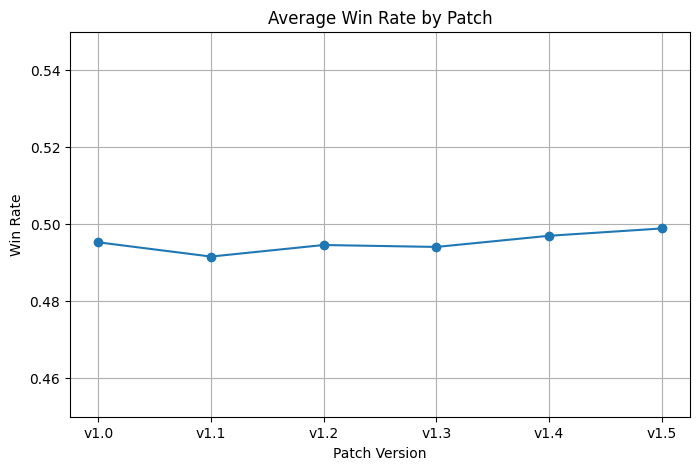

In [3]:
plt.figure(figsize=(8,5))
plt.plot(winrate_patch["patch_version"],
         winrate_patch["win_rate"],
         marker="o")

plt.title("Average Win Rate by Patch")
plt.xlabel("Patch Version")
plt.ylabel("Win Rate")
plt.ylim(0.45, 0.55)
plt.grid(True)
plt.show()


Takeaways:
Win rates remain relatively stable across patches, suggesting that balance updates did not introduce large systemic shifts. Small fluctuations likely reflect targeted adjustments to specific characters rather than broad gameplay changes. This indicates a controlled balance philosophy where changes aim to fine-tune rather than disrupt the meta.

In [4]:
query = """
SELECT rank_tier,
       ROUND(AVG(win), 4) AS win_rate,
       COUNT(*) AS matches
FROM matches
GROUP BY rank_tier
ORDER BY matches DESC;
"""

winrate_rank = pd.read_sql(query, conn)
winrate_rank


,rank_tier,win_rate,matches
0,Gold,0.5526,80545
1,Silver,0.4458,66779
2,Bronze,0.3436,32952
3,Platinum,0.6789,19346
4,Diamond,0.8095,378


In [5]:
query = """
SELECT character,
       COUNT(*) AS picks
FROM matches
GROUP BY character
ORDER BY picks DESC;
"""

pick_rate = pd.read_sql(query, conn)
pick_rate.head(10)


,character,picks
0,op_3,10161
1,op_10,10141
2,op_9,10133
3,op_6,10108
4,op_11,10085
5,op_19,10072
6,op_16,10050
7,op_12,10050
8,op_17,10047
9,op_1,10037


In [12]:
query = """
SELECT character,
       ROUND(AVG(win), 4) AS win_rate,
       COUNT(*) AS matches
FROM matches
GROUP BY character
HAVING matches >= 3000
ORDER BY win_rate DESC;
"""

char_winrate = pd.read_sql(query, conn)
char_winrate.head(10)


,character,win_rate,matches
0,op_15,0.5456,9963
1,op_0,0.5391,10003
2,op_5,0.5352,9864
3,op_2,0.5268,9783
4,op_9,0.5199,10133
5,op_16,0.5168,10050
6,op_13,0.5119,9850
7,op_17,0.5106,10047
8,op_7,0.5103,9976
9,op_18,0.5078,9883


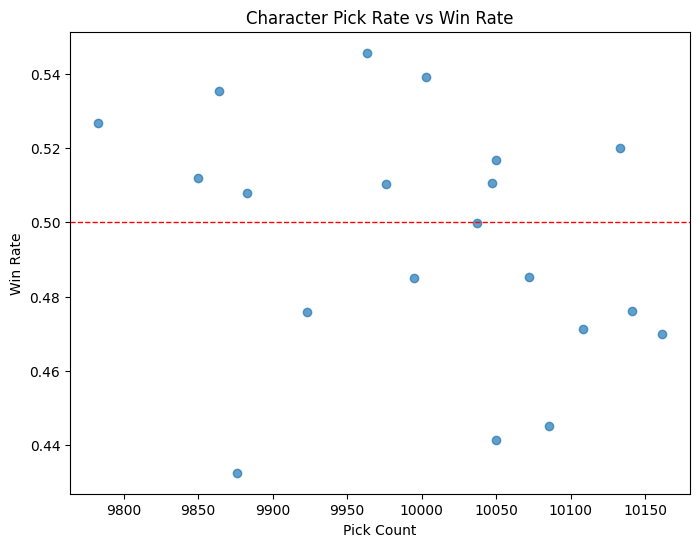

In [11]:
merged = pick_rate.merge(char_winrate, on="character")

plt.figure(figsize=(8,6))
plt.scatter(merged["picks"], merged["win_rate"], alpha=0.7)

plt.xlabel("Pick Count")
plt.ylabel("Win Rate")
plt.title("Character Pick Rate vs Win Rate")

plt.axhline(0.5, color="red", linestyle="--", linewidth=1)
plt.show()


High pick + high win → likely overpowered

Low pick + high win → hidden strong pick

High pick + low win → popular but weak

Takeaways:
While most characters cluster around a 50% win rate, a small number deviate meaningfully. Characters with both high pick rates and above-average win rates may indicate balance risks, whereas low-pick high-win characters suggest underexplored strength. This analysis highlights opportunities for targeted balance adjustments rather than broad systemic changes.

In [13]:
query = """
SELECT rank_tier,
       character,
       ROUND(AVG(win), 4) AS win_rate,
       COUNT(*) AS matches
FROM matches
GROUP BY rank_tier, character
HAVING matches >= 800
ORDER BY rank_tier, win_rate DESC;
"""

rank_char_win = pd.read_sql(query, conn)
rank_char_win.head(10)


,rank_tier,character,win_rate,matches
0,Bronze,op_5,0.4023,1668
1,Bronze,op_15,0.3969,1625
2,Bronze,op_2,0.3811,1632
3,Bronze,op_9,0.3728,1596
4,Bronze,op_16,0.3717,1711
5,Bronze,op_0,0.3674,1633
6,Bronze,op_7,0.3605,1667
7,Bronze,op_18,0.3589,1680
8,Bronze,op_1,0.3578,1691
9,Bronze,op_13,0.3563,1639


In [16]:
# identify lowest and highest rank by median MMR
rank_order = (
    rank_char_win
    .groupby("rank_tier")["win_rate"]
    .median()
    .sort_values()
    .index
)

low_rank = rank_order[0]
high_rank = rank_order[-1]

low_rank, high_rank



('Bronze', 'Platinum')

In [17]:
pivot = rank_char_win.pivot(
    index="character",
    columns="rank_tier",
    values="win_rate"
)

pivot = pivot.dropna(subset=[low_rank, high_rank])
pivot.head()



rank_tier,Bronze,Gold,Platinum,Silver
character,,,,
op_0,0.3674,0.5896,0.7515,0.5006
op_1,0.3578,0.5561,0.6869,0.4445
op_10,0.3181,0.5407,0.6690,0.4190
op_11,0.2993,0.5093,0.6095,0.3901
op_12,0.2987,0.4881,0.6271,0.4011


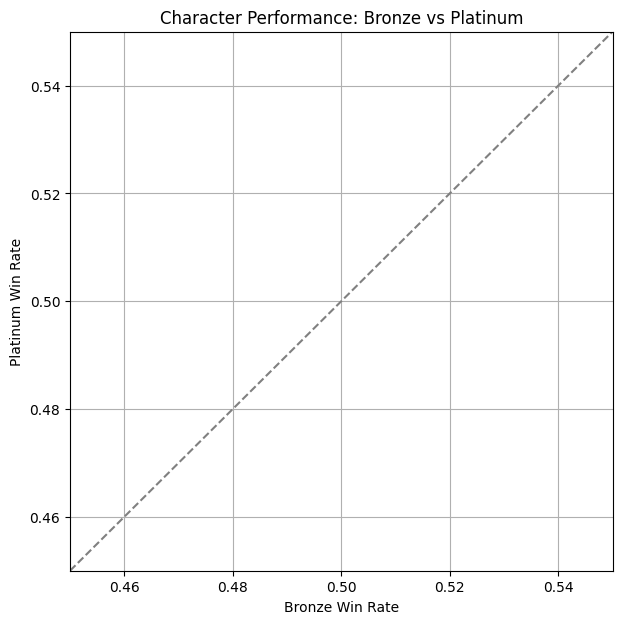

In [18]:
plt.figure(figsize=(7,7))
plt.scatter(pivot[low_rank], pivot[high_rank], alpha=0.7)

plt.plot([0.45, 0.55], [0.45, 0.55], linestyle="--", color="gray")
plt.xlabel(f"{low_rank} Win Rate")
plt.ylabel(f"{high_rank} Win Rate")
plt.title(f"Character Performance: {low_rank} vs {high_rank}")

plt.xlim(0.45, 0.55)
plt.ylim(0.45, 0.55)
plt.grid(True)
plt.show()


Takeaways:
Comparing the lowest and highest skill tiers reveals that while most characters maintain consistent performance, several exhibit skill-dependent win rates. Characters that perform significantly better at higher ranks may reward mechanical mastery or coordination, whereas characters that dominate lower ranks may rely on simpler or more forgiving mechanics. This suggests opportunities for targeted balance adjustments rather than uniform tuning.

In [19]:
pd.read_sql("SELECT * FROM patches LIMIT 5;", conn)


,patch_version,release_date,balance_notes,balance_delta_json
0,v1.0,2025-01-15,Synthetic balance update,"{np.str_('op_13'): 0.0282, np.str_('op_1'): -0..."
1,v1.1,2025-02-05,Synthetic balance update,"{np.str_('op_15'): -0.0005, np.str_('op_13'): ..."
2,v1.2,2025-02-26,Synthetic balance update,"{np.str_('op_15'): 0.014, np.str_('op_3'): -0...."
3,v1.3,2025-03-19,Synthetic balance update,"{np.str_('op_14'): -0.0015, np.str_('op_16'): ..."
4,v1.4,2025-04-09,Synthetic balance update,"{np.str_('op_1'): -0.0106, np.str_('op_18'): 0..."


In [21]:
query = """
SELECT m.character,
       m.patch_version AS patch,
       ROUND(AVG(m.win), 4) AS win_rate,
       COUNT(*) AS matches
FROM matches m
GROUP BY m.character, m.patch_version
HAVING matches >= 600
ORDER BY patch, win_rate DESC;
"""
patch_balance = pd.read_sql(query, conn)
patch_balance.head()


,character,patch,win_rate,matches
0,op_0,v1.0,0.5459,1720
1,op_15,v1.0,0.5401,1670
2,op_9,v1.0,0.5369,1654
3,op_2,v1.0,0.5285,1616
4,op_1,v1.0,0.5233,1653


In [22]:
patches = sorted(patch_balance["patch"].unique())
old_patch, new_patch = patches[0], patches[-1]
old_patch, new_patch


('v1.0', 'v1.5')

In [23]:
patch_pivot = patch_balance.pivot(index="character", columns="patch", values="win_rate")
patch_pivot = patch_pivot.dropna(subset=[old_patch, new_patch])
patch_pivot["delta"] = patch_pivot[new_patch] - patch_pivot[old_patch]

patch_pivot.sort_values("delta", ascending=False).head(5)


patch,v1.0,v1.1,v1.2,v1.3,v1.4,v1.5,delta
character,,,,,,,
op_10,0.4626,0.4825,0.4544,0.4648,0.5009,0.4919,0.0293
op_12,0.4236,0.4516,0.4532,0.4410,0.4361,0.4441,0.0205
op_15,0.5401,0.5507,0.5320,0.5458,0.5460,0.5592,0.0191
op_17,0.4994,0.5296,0.5027,0.5122,0.5012,0.5185,0.0191
op_7,0.4923,0.5072,0.5214,0.5234,0.5084,0.5105,0.0182


In [26]:
patch_pivot.sort_values("delta", ascending=False).head(5)


patch,v1.0,v1.1,v1.2,v1.3,v1.4,v1.5,delta
character,,,,,,,
op_10,0.4626,0.4825,0.4544,0.4648,0.5009,0.4919,0.0293
op_12,0.4236,0.4516,0.4532,0.4410,0.4361,0.4441,0.0205
op_15,0.5401,0.5507,0.5320,0.5458,0.5460,0.5592,0.0191
op_17,0.4994,0.5296,0.5027,0.5122,0.5012,0.5185,0.0191
op_7,0.4923,0.5072,0.5214,0.5234,0.5084,0.5105,0.0182


In [24]:
patch_pivot.sort_values("delta").head(5)


patch,v1.0,v1.1,v1.2,v1.3,v1.4,v1.5,delta
character,,,,,,,
op_1,0.5233,0.5037,0.4882,0.4997,0.4937,0.4903,-0.0330
op_11,0.4648,0.4362,0.4361,0.4513,0.4430,0.4390,-0.0258
op_14,0.5027,0.4687,0.5060,0.4799,0.4727,0.4808,-0.0219
op_9,0.5369,0.5173,0.5184,0.5006,0.5302,0.5169,-0.0200
op_2,0.5285,0.5403,0.5136,0.5416,0.5183,0.5195,-0.0090


The buffs and Nerfs show which ops were actually affected because of the patch.


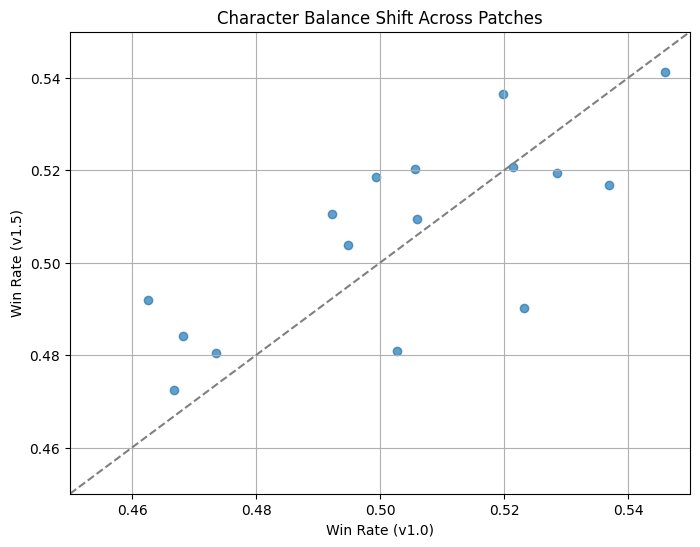

In [25]:
plt.figure(figsize=(8,6))
plt.scatter(patch_pivot[old_patch], patch_pivot[new_patch], alpha=0.7)

plt.plot([0.45, 0.55], [0.45, 0.55], linestyle="--", color="gray")
plt.xlabel(f"Win Rate ({old_patch})")
plt.ylabel(f"Win Rate ({new_patch})")
plt.title("Character Balance Shift Across Patches")
plt.xlim(0.45, 0.55)
plt.ylim(0.45, 0.55)
plt.grid(True)
plt.show()


Patch Impact Analysis:
Comparing character win rates across patches shows that most characters remain close to the diagonal, suggesting conservative balance tuning rather than disruptive changes. However, several characters experienced measurable shifts in performance, indicating targeted adjustments aimed at correcting outliers. Overall, the patch appears to have reduced extreme win-rate deviations while preserving meta stability.

In [27]:
latest_patch = new_patch

latest = patch_pivot[[latest_patch]].rename(
    columns={latest_patch: "win_rate"}
)

latest.head()


patch,win_rate
character,
op_0,0.5413
op_1,0.4903
op_10,0.4919
op_11,0.4390
op_12,0.4441


In [28]:
overpowered = latest[latest["win_rate"] > 0.53]
underpowered = latest[latest["win_rate"] < 0.47]

overpowered.head(), underpowered.head()


(patch      win_rate
 character          
 op_0         0.5413
 op_15        0.5592
 op_5         0.5365,
 patch      win_rate
 character          
 op_11        0.4390
 op_12        0.4441
 op_8         0.4420)

In [30]:
SIM_NERF = -0.03
SIM_BUFF =  0.03
simulated = latest.copy()
simulated["simulated_win_rate"] = simulated["win_rate"]

# Apply nerfs
simulated.loc[simulated.index.isin(overpowered.index),
              "simulated_win_rate"] += SIM_NERF

# Apply buffs
simulated.loc[simulated.index.isin(underpowered.index),
              "simulated_win_rate"] += SIM_BUFF

simulated.head()


patch,win_rate,simulated_win_rate
character,,
op_0,0.5413,0.5113
op_1,0.4903,0.4903
op_10,0.4919,0.4919
op_11,0.4390,0.4690
op_12,0.4441,0.4741


In [31]:
latest["distance_from_50"] = abs(latest["win_rate"] - 0.50)
simulated["distance_from_50"] = abs(simulated["simulated_win_rate"] - 0.50)

latest["distance_from_50"].mean(), simulated["distance_from_50"].mean()


(np.float64(0.02658), np.float64(0.017579999999999995))

Interpretation:

Lower mean distance = better balance

If the number decreases → simulation improved balance

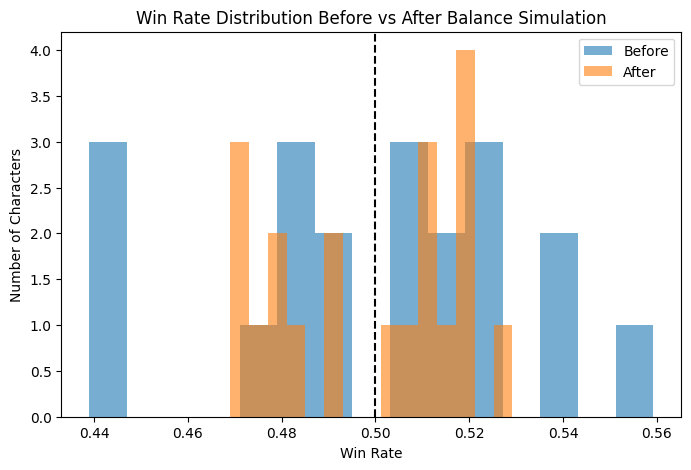

In [32]:
plt.figure(figsize=(8,5))
plt.hist(latest["win_rate"], bins=15, alpha=0.6, label="Before")
plt.hist(simulated["simulated_win_rate"], bins=15, alpha=0.6, label="After")

plt.axvline(0.5, color="black", linestyle="--")
plt.xlabel("Win Rate")
plt.ylabel("Number of Characters")
plt.title("Win Rate Distribution Before vs After Balance Simulation")
plt.legend()
plt.show()


Balance Simulation Insight:
A hypothetical tuning pass applying moderate nerfs to overperforming characters and buffs to underperforming characters reduced overall deviation from a 50% win rate. The simulated distribution shows tighter clustering around the equilibrium, suggesting that small, targeted adjustments could improve balance without destabilizing the meta.